In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [133]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [107]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})

## Download dataset using torchvision

In [59]:
transform = transforms.Compose(
    [transforms.ToTensor()])
     #transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.FashionMNIST(root='./df', train=True,
                                        transform = transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./df', train=False,
                                       transform = transform, download=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
              'Sneaker', 'Bag', 'Ankle Boot')

            Dress        Ankle Boot             Dress             Shirt


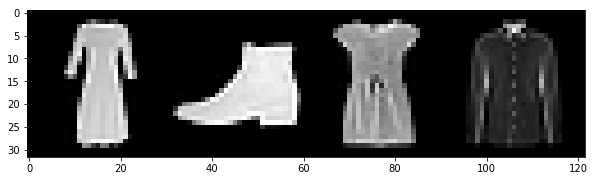

In [60]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
#print(images.size())
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%17s' % classes[labels[j]] for j in range(4)))

Make batch size bigger

In [61]:
BATCH_SIZE = 100
NUM_EPOCHS = 9

In [62]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

## Define a Convolution Neural Network

In [146]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.5))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.5))
        self.fc = nn.Linear(7*7*32, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [147]:
net = Net()
#net.load_state_dict(torch.load('fashion_model_rms_prop.pt'))

## Define a Loss function and optimizer

In [148]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=learning_rate)

## Train the network

In [102]:
loss_list = []
running_loss = 0.0

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
# print statistics
        if i % 300 == 299 :
            loss_list.append(running_loss)
            
            net.eval()
            correct = 0
            total = 0
            # Iterate through test dataset
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Epoch : %d; Iteration : %d; Accuracy : %.3f; loss : %.3f' 
                                    %(epoch, i, correct/total, running_loss))
            net.train()
            running_loss = 0
        
print('Finished Training')

Epoch : 0; Iteration : 299; Accuracy : 0.809; loss : 190.984
Epoch : 0; Iteration : 599; Accuracy : 0.843; loss : 159.028
Epoch : 1; Iteration : 299; Accuracy : 0.857; loss : 145.160
Epoch : 1; Iteration : 599; Accuracy : 0.862; loss : 137.156
Epoch : 2; Iteration : 299; Accuracy : 0.867; loss : 130.471
Epoch : 2; Iteration : 599; Accuracy : 0.869; loss : 126.315
Epoch : 3; Iteration : 299; Accuracy : 0.870; loss : 120.502
Epoch : 3; Iteration : 599; Accuracy : 0.875; loss : 120.120
Epoch : 4; Iteration : 299; Accuracy : 0.878; loss : 114.817
Epoch : 4; Iteration : 599; Accuracy : 0.881; loss : 113.273
Epoch : 5; Iteration : 299; Accuracy : 0.883; loss : 109.816
Epoch : 5; Iteration : 599; Accuracy : 0.887; loss : 109.622
Epoch : 6; Iteration : 299; Accuracy : 0.887; loss : 108.623
Epoch : 6; Iteration : 599; Accuracy : 0.887; loss : 107.100
Epoch : 7; Iteration : 299; Accuracy : 0.891; loss : 104.088
Epoch : 7; Iteration : 599; Accuracy : 0.893; loss : 104.766
Epoch : 8; Iteration : 2

In [97]:
torch.save(net.state_dict(), 'fashion_model_rms_prop.pt')

## График зависимости ошибки от номера эпохи

In [115]:
epoch_num = np.arange(0.5, 9.5, 0.5)

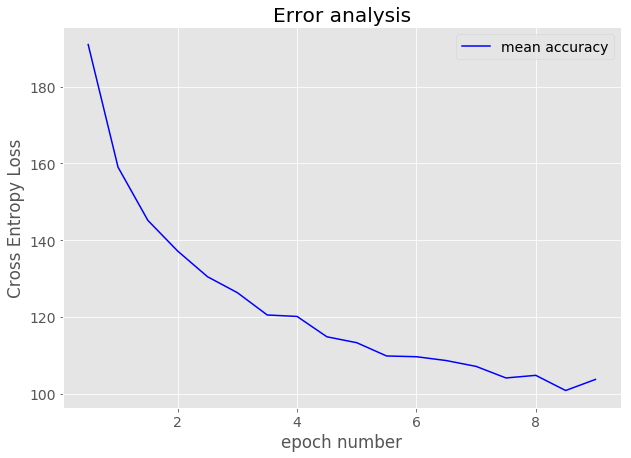

In [121]:
plt.figure(figsize=(10,7))
plt.plot(epoch_num, loss_list, 'b', label='mean accuracy')
plt.title('Error analysis')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch number')
plt.legend(loc='best')
plt.show()

## Кривая обучения в зависимости от шума

In [134]:
def noisy_data(ins, stddev, is_training = True, mean = 0):
    if is_training:
        noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
        return ins + noise
    return ins

## Train the network with noisy data

In [149]:
loss_list_noisy = []
running_loss = 0.0

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        
        # get the inputs
        inputs, labels = data
        noisy_inputs = noisy_data(inputs, stddev=0.3)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(noisy_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
# print statistics
        if i % 300 == 299 :
            loss_list_noisy.append(running_loss)
            
            net.eval()
            correct = 0
            total = 0
            # Iterate through test dataset
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Epoch : %d; Iteration : %d; Accuracy : %.3f; loss : %.3f' 
                                    %(epoch, i, correct/total, running_loss))
            net.train()
            running_loss = 0
        
print('Finished Training')

Epoch : 0; Iteration : 299; Accuracy : 0.759; loss : 270.705
Epoch : 0; Iteration : 599; Accuracy : 0.796; loss : 190.654
Epoch : 1; Iteration : 299; Accuracy : 0.816; loss : 172.115
Epoch : 1; Iteration : 599; Accuracy : 0.818; loss : 166.400
Epoch : 2; Iteration : 299; Accuracy : 0.833; loss : 160.694
Epoch : 2; Iteration : 599; Accuracy : 0.845; loss : 154.533
Epoch : 3; Iteration : 299; Accuracy : 0.846; loss : 153.999
Epoch : 3; Iteration : 599; Accuracy : 0.849; loss : 152.757
Epoch : 4; Iteration : 299; Accuracy : 0.854; loss : 150.647
Epoch : 4; Iteration : 599; Accuracy : 0.853; loss : 148.876
Epoch : 5; Iteration : 299; Accuracy : 0.852; loss : 147.963
Epoch : 5; Iteration : 599; Accuracy : 0.859; loss : 144.970
Epoch : 6; Iteration : 299; Accuracy : 0.852; loss : 143.940
Epoch : 6; Iteration : 599; Accuracy : 0.859; loss : 145.752
Epoch : 7; Iteration : 299; Accuracy : 0.863; loss : 143.221
Epoch : 7; Iteration : 599; Accuracy : 0.851; loss : 143.872
Epoch : 8; Iteration : 2

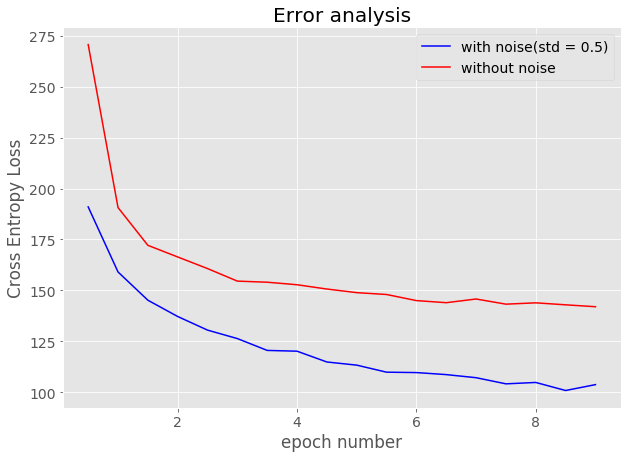

In [151]:
plt.figure(figsize=(10,7))
plt.plot(epoch_num, loss_list, 'b', label='with noise(std = 0.5)')
plt.plot(epoch_num, loss_list_noisy, 'r', label='without noise')
plt.title('Error analysis')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch number')
plt.legend(loc='best')
plt.show()